In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
gpus = tf.config.experimental.list_physical_devices("GPU")
print(gpus)
import numpy as np
import math
import pandas
from matplotlib import pyplot as plt
from PIL import Image
import os


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
index_list = np.linspace(0,2999, 3000).astype(np.uint16)
np.random.shuffle(index_list)
index_list = index_list
print(index_list)

[2536   48 2167 ... 1207 2736  577]


In [3]:
locloc = "BigDataPeople" 
namename = "\Suitman_EEVEE\\SuitMan"
all_photos = np.load(locloc + namename + 'Photos.npy')
#all_labels = np.load(locloc + namename + 'Labels.npy') # Эта штука соответствует одному из значений в all_degrees, котрое соответствует некой маске
#all_vectors = np.load(locloc + namename + 'Vectors.npy')
#all_degrees = np.load(locloc + namename + 'RotationDegrees.npy')
all_albedos = np.load(locloc + namename + 'Albedos.npy')
#all_normals = np.load(locloc + namename + 'Normals.npy')
all_masks = np.load(locloc + namename + 'Masks.npy')
# Цель просто сделать рабочий генератор маски.

In [4]:
locloc = "BigDataPeople" 
namename = "\Knight_EEVEE\\Knight"
all_photos1 = np.load(locloc + namename + 'Photos.npy')
all_albedos1 = np.load(locloc + namename + 'Albedos.npy')
all_masks1 = np.load(locloc + namename + 'Masks.npy')

In [5]:
locloc = "BigDataPeople" 
namename = "\Woman1_EEVEE\\Woman1"
all_photos2 = np.load(locloc + namename + 'Photos.npy')
all_albedos2 = np.load(locloc + namename + 'Albedos.npy')
all_masks2 = np.load(locloc + namename + 'Masks.npy')

In [6]:
all_photos = np.concatenate([all_photos, all_photos1, all_photos2], axis=0) 
all_albedos = np.concatenate([all_albedos, all_albedos1, all_albedos2], axis=0) 
all_masks = np.concatenate([all_masks, all_masks1, all_masks2], axis=0) 
del all_photos1;  del all_photos2;
del all_albedos1; del all_albedos2;
del all_masks1;   del all_masks2;

In [7]:
all_photos = all_photos[index_list]
all_albedos = all_albedos[index_list]
all_masks = all_masks[index_list]
ratio = 0.96; 
all_length = round( len(all_photos) * ratio)

all_photos_test = all_photos[all_length:]
all_albedos_test = all_albedos[all_length:]
all_mask_tests = all_masks[all_length:]

all_photos = all_photos[0: all_length]
all_albedos = all_albedos[0: all_length]
all_masks = all_masks[0: all_length]

In [8]:
all_mask_tests.shape

(120, 64, 64, 3)

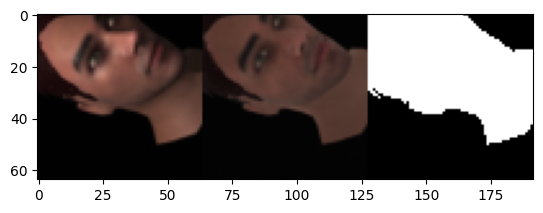

In [9]:
numberouno = 5
plt.imshow(np.concatenate([all_photos[numberouno], all_albedos[numberouno], all_masks[numberouno]], axis = 1).astype(np.float32))

In [10]:
def GetDifference(num_images):
    photo = all_photos[num_images]
    albedo = all_albedos[num_images]
    mask = all_masks[num_images]
    return photo - albedo * mask
def normalizeNegativeImage(imim, mask):
    nonneg = imim - np.ones(imim.shape) * imim.min()
    nmax = 0.01
    if nonneg.max() != 0:
        nmax = nonneg.max()
    nonneg = nonneg * (1.0/nmax)
    return nonneg# * mask

In [11]:
def masstestAlt(mylist, locmodel):
    inputs = all_photos[mylist]
    testanswers = all_albedos[mylist]
    imgimg = locmodel.predict([inputs])
    testanswers2 = all_albedos[mylist]
    imgimg2 = locmodel.predict([inputs])
    for i in range(len(mylist)):
        testanswers2[i] = normalizeNegativeImage(all_albedos[mylist[i]], all_masks[mylist[i]])
        imgimg2[i] = normalizeNegativeImage(imgimg[i], all_masks[mylist[i]])

    r0 =  np.concatenate(inputs, axis=1)
    r1 =  np.concatenate(testanswers, axis=1)
    r2 =  np.concatenate(imgimg, axis=1)
    r3 =  np.concatenate(testanswers2, axis=1)
    r4 =  np.concatenate(imgimg2, axis=1)
    finalimage = np.concatenate([r0, r0 - r1, r0 - r2, r3, r4], axis=0)
                                 #r3,r4, r5], 
    return finalimage

In [12]:
batch_size = 64
train_size = 1
lightjumps = 57
# Test Dataset нужно грузить отдельно

answerList = list()
print(len(all_albedos))
for i in range(len(all_albedos)):
    answerList.append(
        GetDifference(i)
    )               
all_albedos = np.array(answerList)
del answerList;

dataset = tf.data.Dataset.from_tensor_slices((all_photos, all_albedos))

dataset = dataset.shuffle(buffer_size=512, seed=13)

train_dataset = dataset.batch(64, drop_remainder=True)
print(all_photos.shape)

2880
(2880, 64, 64, 3)


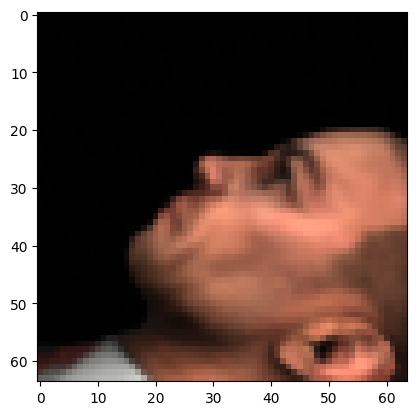

In [13]:
plt.imshow(all_photos[500].astype("float32"))


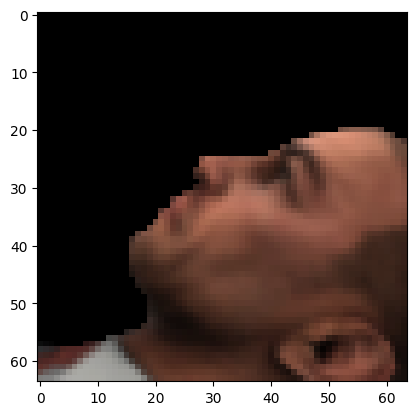

In [14]:
plt.imshow(all_photos[500].astype("float32") - all_albedos[500])


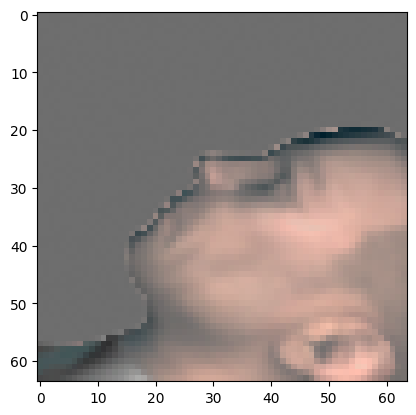

In [15]:
plt.imshow(normalizeNegativeImage(all_albedos[500], all_masks[500]))


In [49]:
def ConvBlock(inputs, filters=64):
    conv1 = keras.layers.Conv2D(filters, kernel_size = (3,3), activation = "tanh", padding = "same")(inputs)
    batch_norm1 = keras.layers.BatchNormalization()(conv1)
    #act1 = keras.layers.tanh()(batch_norm1)
    conv2 = keras.layers.Conv2D(filters, kernel_size = (3,3), activation = "tanh", padding = "same")(conv1)
    batch_norm2 = keras.layers.BatchNormalization()(conv2)
    #act2 = keras.layers.ReLU()(batch_norm2)
    return batch_norm2
def encoder(inputs, filters=64):
    enc1 = ConvBlock(inputs, filters)
    MaxPool1 = keras.layers.MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1
def decoder(inputs, skip, filters=64):
    Upsample = keras.layers.Conv2DTranspose(filters, (2, 2), strides=2, activation='tanh', padding="same")(inputs)
    Connect_Skip = keras.layers.Concatenate()([Upsample, skip])
    out = ConvBlock(Connect_Skip, filters)
    return out
def get_U_Net(image_size):
    inputs = keras.layers.Input(image_size)
    
    skip1, encoder_1 = encoder(inputs, 32)
    skip2, encoder_2 = encoder(encoder_1, 32*2)
    skip3, encoder_3 = encoder(encoder_2, 32*4)
    skip4, encoder_4 = encoder(encoder_3, 32*4)
    
    conv_block = ConvBlock(encoder_4, 32*8)
    
    decoder_1 = decoder(conv_block, skip4, 32*4)
    decoder_2 = decoder(decoder_1, skip3, 32*4)
    decoder_3 = decoder(decoder_2, skip2, 32*2)
    decoder_4 = decoder(decoder_3, skip1, 32)
    
    outputs = keras.layers.Conv2D(3, 1, padding="same", activation="tanh")(decoder_4)
    
    model = keras.models.Model(inputs, outputs)
    return model

In [53]:
def GiveModel():
    image_input = keras.layers.Input(shape=(64, 64, 3), name='image_input')
    x = keras.layers.Conv2D(4, (3, 3), activation='relu', padding="same")(image_input)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Conv2D(7, (3, 3), activation='relu', padding="same")(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Flatten()(x)
    
    # Полносвязный слой
    z = keras.layers.Dense(2*16*16, activation='tanh')(x)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(4*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(6*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(8*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(8*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(8*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    

    resh = keras.layers.Reshape((16, 16, 8))(do)
    anticonv1 = keras.layers.Conv2DTranspose(4, (3, 3), strides=(2,2), padding='same', activation='tanh')(resh)
    output = keras.layers.Conv2DTranspose(3, (3, 3), strides=(2,2), padding='same', activation='tanh')(anticonv1)
    
    # Создание модели
    model = keras.models.Model(inputs=[image_input], outputs=output)
    return model

In [54]:
model = get_U_Net((64,64,3))
#model.summary()
g_optimizer_image=keras.optimizers.Adam(learning_rate=0.00004)
model.compile(optimizer=g_optimizer_image, loss='mse')

In [55]:
'''model = GiveModel()
model.compile(optimizer=g_optimizer_image, loss='mse')
model.summary()'''

"model = GiveModel()\nmodel.compile(optimizer=g_optimizer_image, loss='mse')\nmodel.summary()"

In [88]:
model.fit(train_dataset, epochs=10)

Epoch 1/10
45/45 [==============================] - 3s 69ms/step - loss: 0.0042
Epoch 2/10
45/45 [==============================] - 3s 69ms/step - loss: 0.0041
Epoch 3/10
45/45 [==============================] - 3s 70ms/step - loss: 0.0040
Epoch 4/10
45/45 [==============================] - 3s 72ms/step - loss: 0.0039
Epoch 5/10
45/45 [==============================] - 3s 74ms/step - loss: 0.0038
Epoch 6/10
45/45 [==============================] - 3s 69ms/step - loss: 0.0037
Epoch 7/10
45/45 [==============================] - 3s 69ms/step - loss: 0.0036
Epoch 8/10
45/45 [==============================] - 3s 68ms/step - loss: 0.0034
Epoch 9/10
45/45 [==============================] - 3s 68ms/step - loss: 0.0034
Epoch 10/10
45/45 [==============================] - 3s 69ms/step - loss: 0.0033


1/1 [==============================] - 0s 23ms/step


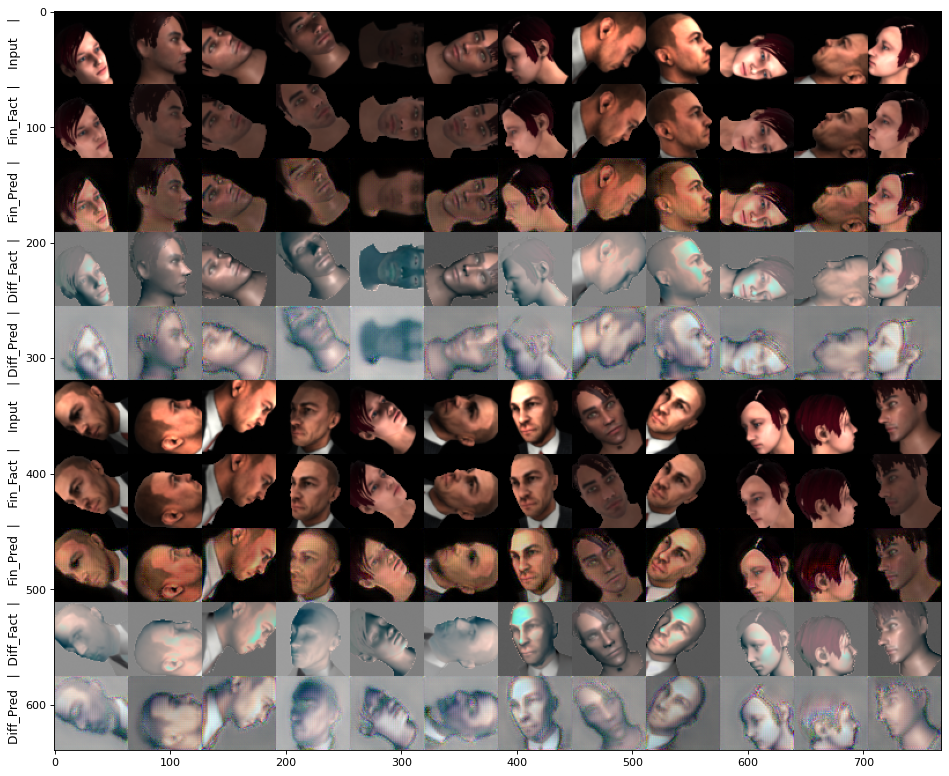

In [96]:
toinset = np.array([i * 50 for i in range(12)])
bigpicture = masstestAlt(toinset, model)
toinset1 = np.array([i * 50 + 25 for i in range(12)])
bigpicture1 = masstestAlt(toinset1, model)
bigpicture = np.concatenate([bigpicture, bigpicture1], axis=0)
plt.figure(figsize=(16, 12), dpi=80)
plt.ylabel("Diff_Pred   |  Diff_Fact  |    Fin_Pred  |    Fin_Fact  |    Input    | Diff_Pred  |  Diff_Fact  |    Fin_Pred  |    Fin_Fact  |    Input    |", fontsize=11)
plt.imshow(bigpicture.astype("float32").clip(0,1))

In [94]:
model.evaluate(all_photos_test, all_albedos_test)

4/4 [==============================] - 0s 20ms/step - loss: 0.0754


0.07535771280527115

1/1 [==============================] - 0s 24ms/step
(24, 64, 64, 3)


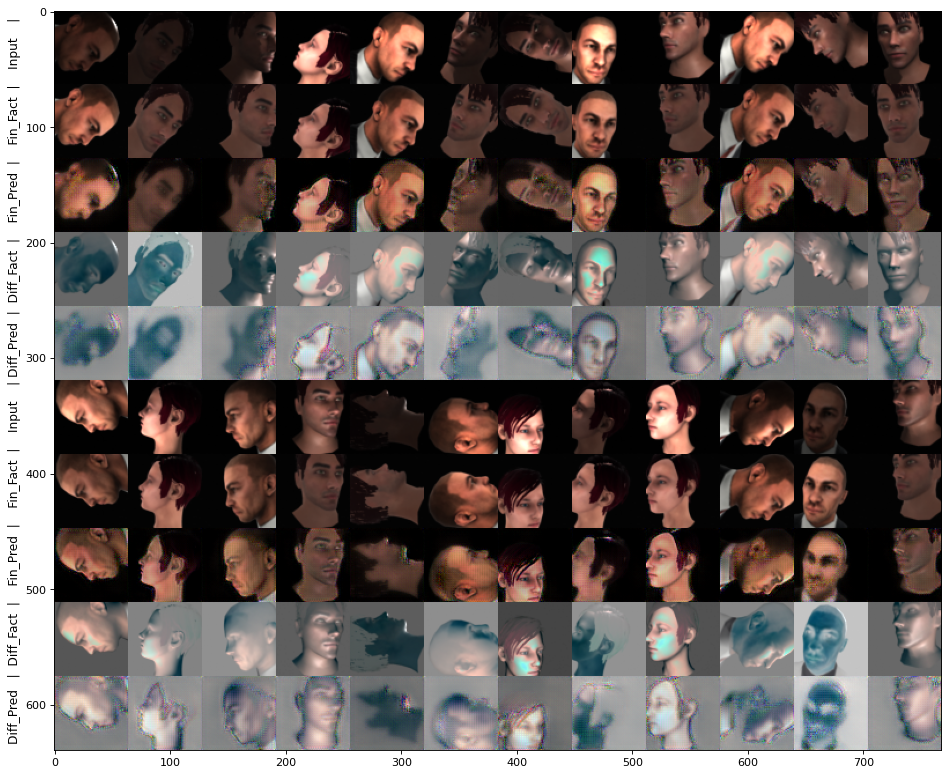

In [107]:
toinset = np.array([i for i in range(24)]); 
test_inputs = all_photos_test[toinset];  

predictions_test = model.predict(test_inputs)
pred_preview = []
for i in range(24):
    pred_preview.append(normalizeNegativeImage(predictions_test[i], np.zeros((64,64,3))  + 1))
pred_preview = np.array(pred_preview)
print(pred_preview.shape)
test_albedos = all_albedos_test[toinset];  

actual_albedos = test_inputs - test_albedos
for i in range(24):
    actual_albedos[i] = normalizeNegativeImage(actual_albedos[i], np.zeros((64,64,3))  + 1)
predicted_albedos = test_inputs -predictions_test
final_image = np.concatenate([
    np.concatenate(test_inputs[0:12], axis=1),
    np.concatenate(test_albedos[0:12], axis=1),
    np.concatenate(predicted_albedos[0:12], axis=1),
    np.concatenate(actual_albedos[0:12], axis=1),
    np.concatenate(pred_preview[0:12], axis=1),

    np.concatenate(test_inputs[12:24], axis=1),
    np.concatenate(test_albedos[12:24], axis=1),
    np.concatenate(predicted_albedos[12:24], axis=1),
    np.concatenate(actual_albedos[12:24], axis=1),
    np.concatenate(pred_preview[12:24], axis=1),
    ], axis = 0
)

plt.figure(figsize=(16, 12), dpi=80)
plt.ylabel("Diff_Pred   |  Diff_Fact  |    Fin_Pred  |    Fin_Fact  |    Input    | Diff_Pred  |  Diff_Fact  |    Fin_Pred  |    Fin_Fact  |    Input    |", fontsize=11)
plt.imshow(final_image.astype("float32").clip(0,1))

1/1 [==============================] - 0s 29ms/step


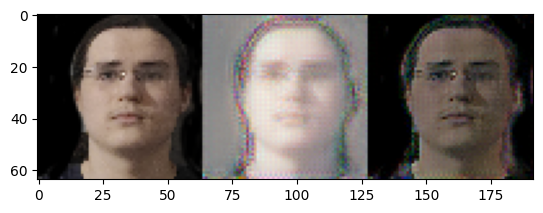

In [108]:
# Вообще работает правильно. Освещенные части оно затемнило, 
# но, из-за того что все картинки в обуч. наборе оранжевые, она затемнила синеватым цветом
dude_pic = Image.open("me.png")
dude_pic = np.array(dude_pic) / 255
dude_albedo = model.predict(dude_pic.reshape((1,64,64,3)))[0]
plt.imshow(np.clip(np.concatenate([dude_pic, normalizeNegativeImage(dude_albedo, np.zeros((64,64,3)) + 1), dude_pic - dude_albedo], axis = 1), 0, 1))

In [110]:
#model.save("human_face_albedo.keras")
# Эта хорошо показывает себя в целом не плохо
# Она хророшо работает с реальными картинками. Может определять светлые места и затенять их
#model.save("human_face__UNET_albedo.keras") 
# Эта хорошо показывает себя на новых данных похожих на обучающие, 
# но у нее проблемы с применением этих знаний к реальным картинкам